# Cost benefit refactoring

In [1]:
import numpy as np

from climada.util.api_client import Client
from climada.entity import ImpactFunc

from climada.entity import LitPop

import copy

client = Client()

In [2]:
# Parameters
ctr_str = "DEU"

# Years to be considered
years = [2000, 2020, 2050]

## Create the snapshots - Exposure, Hazard sets, Impact Functions

## Exposure

### Define the Group

In [3]:
exp_hist = LitPop().from_countries(countries=ctr_str, reference_year=years[0])

# Assign random Group_id of 3 possible to the gdf
reg_id_arr = np.random.randint(0, 3, exp_hist.gdf.shape[0])
exp_hist.gdf["region_id"] = reg_id_arr

2024-06-03 13:49:21,069 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: DEU (276)...



FileNotFoundError: The file /Users/vwattin/climada/data/gpw-v4-population-count-rev11_2000_30_sec_tif/gpw_v4_population_count_rev11_2000_30_sec.tif could not be found. Please download the file first or choose a different folder. The data can be downloaded from http://sedac.ciesin.columbia.edu/data/collection/gpw-v4/sets/browse, e.g., http://sedac.ciesin.columbia.edu/downloads/data/gpw-v4/gpw-v4-population-count-rev11/gpw-v4-population-count-rev11_2000_30_sec_tif.zip (Free NASA Earthdata login required).

In [ ]:
# Present
exp_pres = LitPop().from_countries(countries=ctr_str, reference_year=years[1])
# Assign the region_ids
exp_pres.gdf["region_id"] = reg_id_arr

2024-06-03 11:43:31,792 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: DEU (276)...

2024-06-03 11:43:31,807 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-06-03 11:43:31,818 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-06-03 11:43:31,829 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-06-03 11:43:31,838 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-06-03 11:43:31,847 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-06-03 11:43:31,857 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-06-03 11:43:31,866 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-06-03 11:43:31,875 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2024-06-03 11:43:31,885 - climada.entity.exposures.litpop.gpw_population - 

In [ ]:
# Future
exp_fut = copy.deepcopy(exp_pres)
# Exponential growth
exp_growth_rate = 0.01
exp_fut.gdf.value = exp_fut.gdf.value * (1 + exp_growth_rate) ** (years[2] - years[1])
# Assign the region_ids
exp_fut.gdf["region_id"] = reg_id_arr

## Hazard sets

In [ ]:
haz_fl_1980 = client.get_hazard(
    hazard_type="river_flood",
    properties={
        "climate_scenario": "historical",
        "year_range": "1980_2000",
        "country_iso3alpha": "DEU",
    },
)

2024-06-03 11:46:12,501 - climada.hazard.io - INFO - Reading /Users/ckropf/climada/data/hazard/river_flood/river_flood_150arcsec_hist_DEU_1980_2000/v2/river_flood_150arcsec_hist_DEU_1980_2000.hdf5


In [ ]:
haz_fl_2010 = client.get_hazard(
    hazard_type="river_flood",
    properties={
        "climate_scenario": "rcp85",
        "year_range": "2010_2030",
        "country_iso3alpha": "DEU",
    },
)

2024-06-03 11:46:18,931 - climada.hazard.io - INFO - Reading /Users/ckropf/climada/data/hazard/river_flood/river_flood_150arcsec_rcp85_DEU_2010_2030/v3/river_flood_150arcsec_rcp85_DEU_2010_2030.hdf5


In [ ]:
haz_fl_2030 = client.get_hazard(
    hazard_type="river_flood",
    properties={
        "climate_scenario": "rcp85",
        "year_range": "2030_2050",
        "country_iso3alpha": "DEU",
    },
)

2024-06-03 11:46:25,145 - climada.hazard.io - INFO - Reading /Users/ckropf/climada/data/hazard/river_flood/river_flood_150arcsec_rcp85_DEU_2030_2050/v3/river_flood_150arcsec_rcp85_DEU_2030_2050.hdf5


### Impact Functions

In [ ]:
from climada_petals.entity.impact_funcs.river_flood import (
    ImpfRiverFlood,
    flood_imp_func_set,
)
from climada.entity import ImpactFunc, ImpactFuncSet

impf_set_flood = flood_imp_func_set()

impf_1 = impf_set_flood.get_func(fun_id=1, haz_type="RF")
impf_2 = impf_set_flood.get_func(fun_id=2, haz_type="RF")
impfset = ImpactFuncSet([impf_1, impf_2])

In [ ]:
impfset.get_func(haz_type="RF")[0].id

1

In [ ]:
x = {"1": 1}

In [ ]:
x[2]

KeyError: 2

In [ ]:
def assign_impfid(exp_hist, exp_pres, exp_fut, case="single"):
    if case == "single":
        exp_hist.gdf["impf_RF"] = 1
        exp_pres.gdf["impf_RF"] = 1
        exp_fut.gdf["impf_RF"] = 1
    if case == "multiple_spatial":
        exp_hist.gdf.loc[: len(exp_hist.gdf / 2), "impf_RF"] = 1
        exp_pres.gdf[: len(exp_pres.gdf / 2), "impf_RF"] = 1
        exp_fut.gdf[: len(exp_fut.gdf / 2), "impf_RF"] = 1
        exp_hist.gdf.loc[len(exp_hist.gdf / 2) :, "impf_RF"] = 2
        exp_pres.gdf[len(exp_pres.gdf / 2) :, "impf_RF"] = 2
        exp_fut.gdf[len(exp_fut.gdf / 2) :, "impf_RF"] = 2
    if case == "multiple_temp":
        exp_hist.gdf["impf_RF"] = 1
        exp_pres.gdf["impf_RF"] = 1
        exp_fut.gdf["impf_RF"] = 2
    if case == " multiple":
        exp_hist.gdf.loc[: len(exp_hist.gdf / 2), "impf_RF"] = 1
        exp_pres.gdf[: len(exp_hist.gdf / 2), "impf_RF"] = 2
        exp_fut.gdf[: len(exp_hist.gdf / 2), "impf_RF"] = 1
        exp_hist.gdf.loc[len(exp_hist.gdf / 2) :, "impf_RF"] = 2
        exp_pres.gdf[len(exp_hist.gdf / 2) :, "impf_RF"] = 1
        exp_fut.gdf[len(exp_hist.gdf / 2) :, "impf_RF"] = 2

## From impacts to NPV

### Timeseries

In [ ]:
from climada.hazard import Hazard

haz_series = Hazard.concat([haz_fl_1980, haz_fl_2010, haz_fl_2030])

In [ ]:
impact_set = {}
exposures = {}

assign_impfid(exp_hist, exp_pres, exp_fut, case="single")

for year in range(1980, 2051, 1):
    if year <= 2010:
        exposures[year] = exp_hist
    if year <= 2030:
        exposures[year] = exp_pres
    if year > 2030:
        exposures[year] = exp_fut

for year in range(1980, 2051, 1):
    print(f"Processing year {year}")
    exp = exposures[year]["exp"]
    haz = haz_series.select([f"{str(year)}-01-01", f"{str(year+1)}-01-01"])
    impact_set[year] = ImpactCalc(exp, impfset, haz).impact()

Processing year 1980


TypeError: Since CLIMADA 2.0, Exposures objects are not subscriptable. Data fields of Exposures objects are accessed using the `gdf` attribute. For example, `expo['value']` is replaced by `expo.gdf['value']`.

In [ ]:
# a bit more complicated, do it user
def exposures_merger(exp_list):
    gdf_0 = exp_list[0].gdf[["geometry", "value"]]
    for n, exp in enumerate(exp_list[1:]):
        print(n)
        gdf_0 = gdf_0.sjoin(exp.gdf[["geometry", "value"]], rsuffix=f"{n}")
    return gdf_0

### Snapshots 

In [ ]:
assign_impfid(exp_hist, exp_pres, exp_fut, case="single")
snapshots = {
    years[0]: [exp_hist, impfset, haz_fl_1980],
    years[1]: [exp_pres, impfset, haz_fl_2010],
    years[2]: [exp_fut, impfset, haz_fl_2030],
}

### Fetching the groups

In [ ]:
# Parameters
group_col_str = "region_id"


def create_group_map_exp_dict(snapshots, group_col_str=None):
    """
    Create a dictionary that maps each group to the indices of the exposures in the gdf.
    """

    if group_col_str:
        # Get the first snapshot exposures gdf
        gdf = snapshots[list(snapshots.keys())[0]][0].gdf
        # Get the unique groups
        unique_groups = list(gdf[group_col_str].unique())
        # Create the dictionary
        group_map_exp_dict = {
            i: list(np.where(gdf[group_col_str] == i)[0]) for i in unique_groups
        }

    return group_map_exp_dict


group_map_exp_dict = create_group_map_exp_dict(snapshots, group_col_str)

#### Calculate necessary risk metrics – yearly aai, rp, eai 

In [ ]:
from climada.engine import Impact, ImpactCalc

In [ ]:
impact_snapshots = {}
for year, [exp, impf, haz] in snapshots.items():
    impact_snapshots[year] = ImpactCalc(exp, impf, haz).impact()

2024-05-29 09:30:30,968 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-05-29 09:30:30,976 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-05-29 09:30:31,649 - climada.engine.impact_calc - INFO - Calculating impact for 1969149 assets (>0) and 920 events.
2024-05-29 09:30:31,785 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-05-29 09:30:31,792 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-05-29 09:30:32,456 - climada.engine.impact_calc - INFO - Calculating impact for 1969149 assets (>0) and 480 events.
2024-05-29 09:30:32,633 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-05-29 09:30:32,639 - climada.util.coordinates - INFO - No exact centroid match

### Calculate the expect annual impact between snapshots 2000 and 2020 

In [ ]:
from scipy.sparse import lil_matrix


def interpolate_sm(mat_start, mat_end, year, year_start, year_end):
    if year < year_start or year > year_end:
        raise ValueError("Year must be within the start and end years")

    # Calculate the ratio of the difference between the target year and the start year
    # to the total number of years between the start and end years
    ratio = (year - year_start) / (year_end - year_start)

    # Convert the input matrices to a format that allows efficient modification of its elements
    mat_start = lil_matrix(mat_start)
    mat_end = lil_matrix(mat_end)

    # Perform the linear interpolation
    mat_interpolated = mat_start + ratio * (mat_end - mat_start)

    return mat_interpolated


# Derive the intermediate propability distributions
def interpolate_years(year_start, year_end):
    # Generate an array of interpolated values between 0 and 1
    values = np.linspace(0, 1, num=year_end - year_start + 1)
    return values


# Derive the intermediate propability distributions
prop_H1 = interpolate_years(years[0], years[1])
prop_H0 = 1 - prop_H1

# Define the start and end years
start_year = years[0]
end_year = years[1]

# Case 1 - H2000# Impact 1)  Hazard 2000  and Exposure 2000
imp_eE0H0 = ImpactCalc(exp_hist, impfset, haz_fl_1980).impact()
imp_E1H0 = ImpactCalc(
    exp_pres, impfset, haz_fl_1980
).impact()  # Impact 2)  Hazard 2000  and Exposure 2020

# Case 2 - H2020
# Impact 1)  Hazard 2000  and Exposure 2000
imp_E0H1 = ImpactCalc(exp_hist, impfset, haz_fl_2010).impact()
imp_E1H1 = ImpactCalc(exp_pres, impfset, haz_fl_2010).impact()

2024-05-29 11:54:14,906 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-05-29 11:54:14,907 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2024-05-29 11:54:14,907 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-05-29 11:54:14,919 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-05-29 11:54:15,614 - climada.engine.impact_calc - INFO - Calculating impact for 1969149 assets (>0) and 920 events.
2024-05-29 11:54:15,752 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-05-29 11:54:15,753 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2024-05-29 11:54:15,753 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-05-29 11:54:15,762 - climada

### Define the annual risk metric calculation functions

In [ ]:
def get_eai_exp(eai_exp, group_map):
    eai_region_id = []
    for _, exp_indices in group_map.items():
        eai_region_id.append(np.sum(eai_exp[exp_indices]))
    return eai_region_id


def calc_freq_curve(imp_mat_intrpl, frequency, return_per=None):
    """
    Calculate the frequency curve

    Parameters:
    imp_mat_intrpl (np.array): The interpolated impact matrix
    frequency (np.array): The frequency of the hazard
    return_per (np.array): The return period

    Returns:
    ifc_return_per (np.array): The impact exceeding frequency
    ifc_impact (np.array): The impact exceeding the return period
    """

    # Calculate the at_event make the np.array
    at_event = np.sum(imp_mat_intrpl, axis=1).A1

    # Sort descendingly the impacts per events
    sort_idxs = np.argsort(at_event)[::-1]
    # Calculate exceedence frequency
    exceed_freq = np.cumsum(frequency[sort_idxs])
    # Set return period and impact exceeding frequency
    ifc_return_per = 1 / exceed_freq[::-1]
    ifc_impact = at_event[sort_idxs][::-1]

    if return_per is not None:
        interp_imp = np.interp(return_per, ifc_return_per, ifc_impact)
        ifc_return_per = return_per
        ifc_impact = interp_imp

    return ifc_impact

### Calculate the annual risk metrics – No measure

In [ ]:
# Defaul return period
return_per = np.array([100, 500, 1000])

# Calculate the AAI for each year
aai_0 = []
eai_exp_0 = []
eai_region_id_0 = []
rp_0 = []
at_event_0 = []
frequency = haz_fl_1980.frequency
for year in range(start_year, end_year + 1):
    imp_mat_intrpl = interpolate_sm(
        imp_E0H0.imp_mat, imp_E1H0.imp_mat, year, start_year, end_year
    )
    # sum across the rows of the sparse matrix
    eai_exp = ImpactCalc.eai_exp_from_mat(imp_mat_intrpl, frequency)
    # Calculate the return period
    rp_0.append(calc_freq_curve(imp_mat_intrpl, frequency, return_per))
    # Region_id (Groups)
    eai_region_id_0.append(get_eai_exp(eai_exp, group_map_exp_dict))
    eai_exp_0.append(eai_exp)
    aai_0.append(ImpactCalc.aai_agg_from_eai_exp(eai_exp))
    at_event_0.append(ImpactCalc.at_event_from_mat(imp_mat_intrpl))

# Calculate the AAI for each year
aai_1 = []
eai_exp_1 = []
eai_region_id_1 = []
rp_1 = []
at_event_1 = []
frequency = haz_fl_2010.frequency
for year in range(start_year, end_year + 1):
    imp_mat_intrpl = interpolate_sm(
        imp_E0H1.imp_mat, imp_E1H1.imp_mat, year, start_year, end_year
    )
    # sum across the rows of the sparse matrix
    eai_exp = ImpactCalc.eai_exp_from_mat(imp_mat_intrpl, frequency)
    # Calculate the return period
    rp_1.append(calc_freq_curve(imp_mat_intrpl, frequency, return_per))
    # Region_id (Groups)
    eai_region_id_1.append(get_eai_exp(eai_exp, group_map_exp_dict))
    eai_exp_1.append(eai_exp)
    aai_1.append(ImpactCalc.aai_agg_from_eai_exp(eai_exp))
    at_event_1.append(ImpactCalc.at_event_from_mat(imp_mat_intrpl))

# Average Annual Impact across the years
aai = prop_H0 * aai_0 + prop_H1 * aai_1
# EAI exp across bthe years
eai = np.multiply(prop_H0.reshape(-1, 1), eai_exp_0) + np.multiply(
    prop_H1.reshape(-1, 1), eai_exp_1
)
# EAI region_id across the years
eai_region_id = np.multiply(prop_H0.reshape(-1, 1), eai_region_id_0) + np.multiply(
    prop_H1.reshape(-1, 1), eai_region_id_1
)
# Return period across the years
rp = np.multiply(prop_H0.reshape(-1, 1), rp_0) + np.multiply(
    prop_H1.reshape(-1, 1), rp_1
)

### Calculate the NPV (between years 2000 to 2020)

#### Define the discount rate

<Axes: title={'center': 'Discount rates'}, xlabel='Year', ylabel='discount rate (%)'>

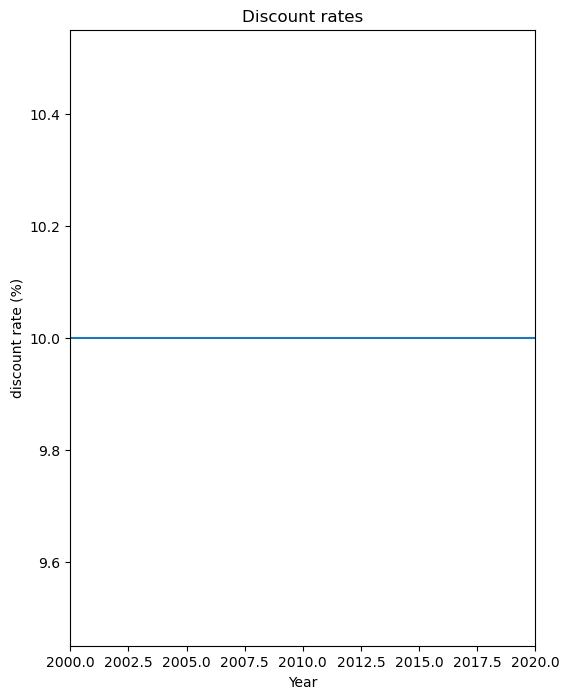

In [ ]:
import numpy as np
from climada.entity import DiscRates
from climada.util import finance as u_fin

# define discount rates
path_years = np.arange(years[0], years[1] + 1)
# INcrease the discount rate to 1.4%
rates = np.linspace(0.10, 0.10, path_years.size)
disc = DiscRates(years=path_years, rates=rates)
disc.plot()

#### Calc the NPV

In [ ]:
NPV = u_fin.net_present_value(disc.years, disc.rates, aai)
print(f"Expected NPV: {NPV}")

# NPV = np.sum(aai/np.array([(1 + disc.rates)**n for n in range(len(aai))]))
# print(f"Expected NPV: {NPV}")

Expected NPV: 433868364873.73773


In [ ]:
"""Compute impact exceedance frequency curve.

Parameters
----------
return_per : np.array, optional
    return periods where to compute
    the exceedance impact. Use impact's frequencies if not provided

Returns
-------
ImpactFreqCurve
"""

at_event = np.array([1, 2, 3, 4, 5])
frequency = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
return_per = np.array([5, 100, 200, 500, 1000, 20000])

# Sort descendingly the impacts per events
sort_idxs = np.argsort(at_event)[::-1]
# Calculate exceedence frequency
exceed_freq = np.cumsum(frequency[sort_idxs])
# Set return period and impact exceeding frequency
ifc_return_per = 1 / exceed_freq[::-1]
ifc_impact = at_event[sort_idxs][::-1]

interp_imp = np.interp(return_per, ifc_return_per, ifc_impact)
ifc_return_per = return_per
# percentiles = 1/ifc_return_permultiply the frequency with the impact matrix such that each row is multiplied by the frequency for the respective event

# sum across the rows of the sparse matrix

In [ ]:
interp_imp

array([4., 5., 5., 5., 5., 5.])

In [ ]:
def calculate_return_periods(event_impacts, annual_frequencies, return_periods):
    # Calculate annual total impact
    annual_total_impact = np.dot(event_impacts, annual_frequencies)

    # Define the function to get the percentile for a given return period
    def get_percentile(return_period):
        return 100 * (1 - 1 / return_period)

    # Calculate the percentiles and values
    percentiles = [get_percentile(rp) for rp in return_periods]
    values = np.percentile(annual_total_impact, percentiles)

    # Convert percentiles to probabilities (1 - percentile/100)
    probabilities = [1 - p / 100 for p in percentiles]

    return np.array(probabilities), np.array(values)


# Example usage
event_impacts = np.array([10, 20, 30, 40, 50])
annual_frequencies = np.array([0.01, 0.01, 0.01, 0.04, 0.01])
return_periods = [100, 200, 500, 1000, 2000]

probabilities, values = calculate_return_periods(
    event_impacts, annual_frequencies, return_periods
)
print("Probabilities:", probabilities)
print("Values:", values)

Probabilities: [0.01   0.005  0.002  0.001  0.0005]
Values: [2.7 2.7 2.7 2.7 2.7]


In [ ]:
impact_snapshots[year]

In [ ]:
mat0 = impact_snapshots[years[0]].imp_mat
mat1 = impact_snapshots[years[1]].imp_mat

## Measures

In [ ]:
from climada.entity import Measure, MeasureSet

In [ ]:
meas1 = Measure(name="meas1", haz_type="RF", cost=100, mdd_impact=(0.9, 0))
meas1.start = years[0]
meas1.end = years[1]

In [ ]:
meas2 = Measure(name="meas2", haz_type="RF", cost=10000, hazard_inten_imp=(0.7, 0))
meas2.start = years[0]
meas2.end = years[2]

In [ ]:
meas3 = Measure(name="meas3", haz_type="RF", cost=100, imp_fun_map="1to2")
meas3.start = years[0] + 5
meas3.end = years[1]

/Users/ckropf/Documents/Climada/climada_python/climada/entity/impact_funcs/base.py:140: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(self.intensity, self.mdd * 100, 'b', label='MDD', **kwargs)
/Users/ckropf/Documents/Climada/climada_python/climada/entity/impact_funcs/base.py:141: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  axis.plot(self.intensity, self.paa * 100, 'r', label='PAA', **kwargs)
/Users/ckropf/Documents/Climada/climada_python/climada/entity/impact_funcs/base.py:142: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axis.plot(self.intensity, self.mdd * self.paa * 100, 'k--', label='MDR', **kwargs)


<Axes: title={'center': 'RF 2: Flood Asia JRC Residential noPAA'}, xlabel='Intensity (m)', ylabel='Impact (%)'>

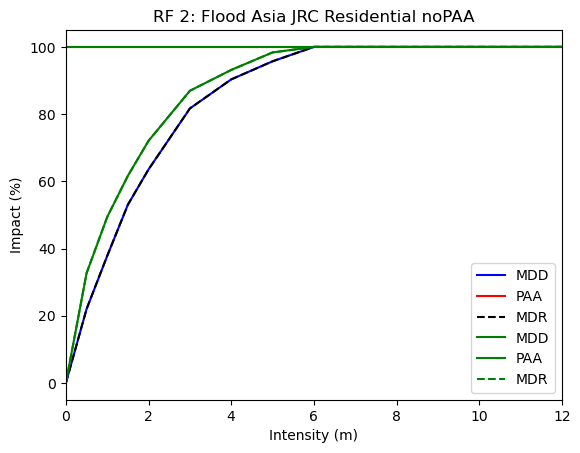

In [ ]:
ax = impfset.get_func(haz_type="RF", fun_id=1).plot()
impfset.get_func(haz_type="RF", fun_id=2).plot(axis=ax, color="g")

In [ ]:
meas_set = MeasureSet([meas1, meas2, meas3])

In [ ]:
meas1.apply(exp, impfset, haz)

(<climada.entity.exposures.litpop.litpop.LitPop at 0x1dcba4af0>,
 <climada.hazard.base.Hazard at 0x1dcbe0370>)

In [ ]:
from scipy.sparse import lil_matrix


def interpolate_sm(mat_start, mat_end, year, year_start, year_end):
    if year < year_start or year > year_end:
        raise ValueError("Year must be within the start and end years")

    # Calculate the ratio of the difference between the target year and the start year
    # to the total number of years between the start and end years
    ratio = (year - year_start) / (year_end - year_start)

    # Convert the input matrices to a format that allows efficient modification of its elements
    mat_start = lil_matrix(mat_start)
    mat_end = lil_matrix(mat_end)

    # Perform the linear interpolation
    mat_interpolated = mat_start + ratio * (mat_end - mat_start)

    return mat_interpolated


# Derive the intermediate propability distributions
def interpolate_years(year_start, year_end):
    # Generate an array of interpolated values between 0 and 1
    values = np.linspace(0, 1, num=year_end - year_start + 1)
    return values


# Derive the intermediate propability distributions
prop_H1 = interpolate_years(years[0], years[1])
prop_H0 = 1 - prop_H1

# Define the start and end years
start_year = years[0]
end_year = years[1]

# Case 1 - H2000# Impact 1)  Hazard 2000  and Exposure 2000
imp_E0H0 = ImpactCalc(exp_hist, impfset, haz_fl_1980).impact()
imp_E1H0 = ImpactCalc(
    exp_pres, impfset, haz_fl_1980
).impact()  # Impact 2)  Hazard 2000  and Exposure 2020

# Case 2 - H2020
# Impact 1)  Hazard 2000  and Exposure 2000
imp_E0H1 = ImpactCalc(exp_hist, impfset, haz_fl_2010).impact()
imp_E1H1 = ImpactCalc(exp_pres, impfset, haz_fl_2010).impact()

2024-05-29 11:01:37,588 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-05-29 11:01:37,588 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2024-05-29 11:01:37,589 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-05-29 11:01:37,597 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-05-29 11:01:38,292 - climada.engine.impact_calc - INFO - Calculating impact for 1969149 assets (>0) and 920 events.
2024-05-29 11:01:38,422 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-05-29 11:01:38,422 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2024-05-29 11:01:38,423 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-05-29 11:01:38,429 - climada

In [ ]:
# Define the start and end years
start_year = meas3.start
end_year = meas3.end

def interp_exp(year, exp1, year1, exp2, year2):
    exp = exp1.copy()
    years_mult = interpolate_years(year1, year2)
    exp.gdf.value = years_mult[year - year1] * exp1.gdf.value + (1 - years_mult[year - year1]) * exp2.gdf.value
    return exp
exp_mid = interp_exp(year=meas3.start, exp_hist, years[0], exp_pres, years[1])

# Snapshots
# Haz impfset and exp at first meas application time
m_exp, m_impf, m_haz = meas3.apply(exp_mid, impfset, haz_fl_1980)
# Haz impfset and exp at second meas application time
m_exp_2, m_impf_2, m_haz_2 = meas3.apply(exp_pres, impfset, haz_fl_2010)

In [ ]:
imp_mE0H0 = ImpactCalc(m_exp, m_impf, m_haz).impact()
imp_mE1H0 = ImpactCalc(
    m_exp_2, m_impf_2, m_haz
).impact()  # Impact 2)  Hazard 2000  and Exposure 2020

imp_mE0H1 = ImpactCalc(m_exp, m_impf, m_haz_2).impact()
imp_mE1H1 = ImpactCalc(
    m_exp_2, m_impf_2, m_haz_2
).impact()  # Impact 2)  Hazard 2000  and Exposure 2020

2024-05-29 11:40:15,609 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-05-29 11:40:15,609 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2024-05-29 11:40:15,610 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-05-29 11:40:15,617 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2024-05-29 11:40:16,304 - climada.engine.impact_calc - INFO - Calculating impact for 1969149 assets (>0) and 920 events.
2024-05-29 11:40:16,445 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for RF
2024-05-29 11:40:16,446 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for RF
2024-05-29 11:40:16,446 - climada.entity.exposures.base - INFO - Matching 661396 exposures with 26472 centroids.
2024-05-29 11:40:16,454 - climada

In [ ]:
# Calculate the AAI for each year
aai_0 = []
eai_exp_0 = []
eai_region_id_0 = []
frequency = haz_fl_1980.frequency
for year in range(start_year, end_year + 1):
    imp_mat_intrpl = interpolate_sm(
        imp_mE0H0.imp_mat, imp_mE1H0.imp_mat, year, start_year, end_year
    )
    # sum across the rows of the sparse matrix
    eai_exp = ImpactCalc.eai_exp_from_mat(imp_mat_intrpl, frequency)
    # Region_id (Groups)
    eai_region_id_0.append(get_eai_exp(eai_exp, group_map_exp_dict))
    eai_exp_0.append(eai_exp)
    aai_0.append(ImpactCalc.aai_agg_from_eai_exp(eai_exp))

# Calculate the AAI for each year
aai_1 = []
eai_exp_1 = []
eai_region_id_1 = []
frequency = haz_fl_2010.frequency
for year in range(start_year, end_year + 1):
    imp_mat_intrpl = interpolate_sm(
        imp_mE0H1.imp_mat, imp_mE1H1.imp_mat, year, start_year, end_year
    )
    # sum across the rows of the sparse matrix
    eai_exp = ImpactCalc.eai_exp_from_mat(imp_mat_intrpl, frequency)
    # Region_id (Groups)
    eai_region_id_1.append(get_eai_exp(eai_exp, group_map_exp_dict))
    eai_exp_1.append(eai_exp)
    aai_1.append(ImpactCalc.aai_agg_from_eai_exp(eai_exp))

m_prop_H0 = prop_H0[start_year - years[0] :]
m_prop_H1 = prop_H1[start_year - years[0] :]
# Average Annual Impact across the years
m_aai = m_prop_H0 * aai_0 + m_prop_H1 * aai_1
# EAI exp across bthe years
m_eai = np.multiply(m_prop_H0.reshape(-1, 1), eai_exp_0) + np.multiply(
    m_prop_H1.reshape(-1, 1), eai_exp_1
)
# EAI region_id across the years
m_eai_region_id = np.multiply(m_prop_H0.reshape(-1, 1), eai_region_id_0) + np.multiply(
    m_prop_H1.reshape(-1, 1), eai_region_id_1
)

In [ ]:
mtot_aai = np.concatenate([aai[0 : start_year - years[0]], m_aai])
mtot_eai = np.concatenate([eai[0 : start_year - years[0]], m_eai])
mtot_eai = np.concatenate([eai_region_id[0 : start_year - years[0]], m_eai_region_id])

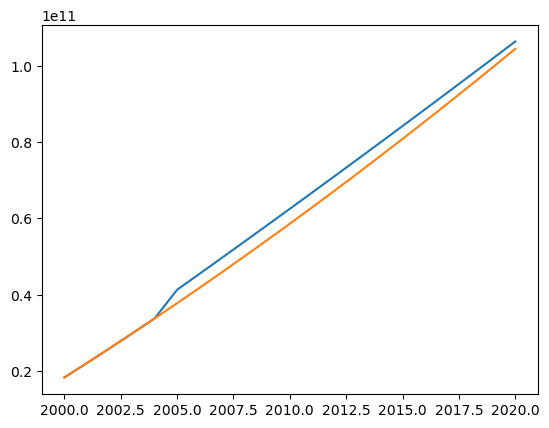

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(years[0], years[1] + 1), mtot_aai)
plt.plot(np.arange(years[0], years[1] + 1), aai)

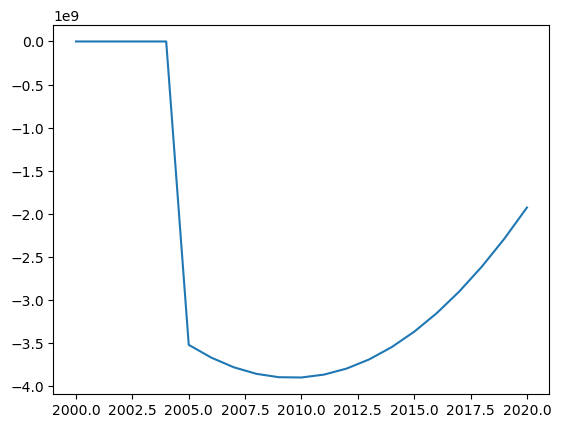

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(years[0], years[1] + 1), aai - mtot_aai)

## Make measures

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
from climada.entity.measures.base import (
    Measure,
    helper_hazard,
    helper_impfset,
    helper_exposure,
)

In [69]:
haz_func = helper_hazard(0.7, -1)
exp_func = helper_exposure(reassign_impf_id=2, haz_type="RF")
impfset_func = helper_impfset(haz_type="RF", impf_mdd_modifier={2: (0.6, 0)})

In [70]:
meas1 = Measure(
    name="test1",
    start_year=2015,
    end_year=2040,
    exposures_change=exp_func,
    impfset_change=impfset_func,
    hazard_change=haz_func,
)

In [71]:
meas1.apply(exp_hist, impfset, haz_fl_1980)

(<climada.entity.exposures.litpop.litpop.LitPop at 0x1c65c9e70>,
 <climada.hazard.base.Hazard at 0x1c65c93c0>)

In [ ]:
meas1.apply(exp_hist, impfset, haz_fl_1980)

## Cash flows

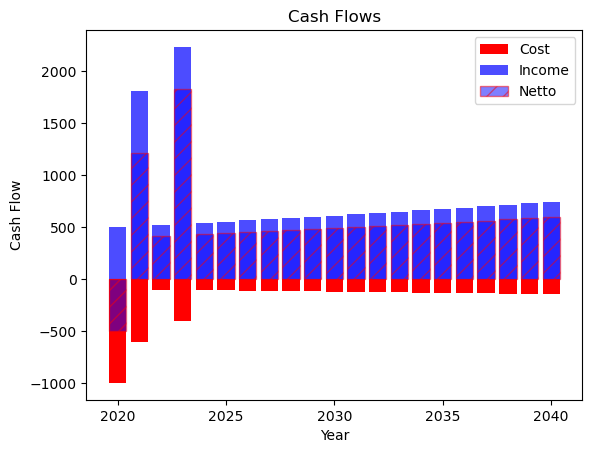

Total Net Present Value: 11613.326877958432


In [6]:
# Example usage
import numpy as np
from climada.entity import DiscRates
from climada.entity.measures.cash_flows import Cost, Income, CostIncomeAnalysis
import pandas as pd

# Define custom costs and incomes
custom_cash_flows = pd.DataFrame(
    {
        "year": [2021, 2021, 2023, 2023],
        "Cost": [200, 300, 150, 150],
        "Income": [600, 700, 800, 900],
    }
)

cost = Cost(
    mkt_price_year=2020,
    initial_cash_flow=1000,
    yearly_cash_flow=100,
    annual_growth_rate=0.02,
    custom_cash_flows_df=custom_cash_flows,
)
income = Income(
    mkt_price_year=2020,
    initial_cash_flow=0,
    yearly_cash_flow=500,
    annual_growth_rate=0.02,
    custom_cash_flows_df=custom_cash_flows,
)

# Define discount rates
years = np.arange(1950, 2100)
rates = np.ones(years.size) * 0.014
rates[51:55] = 0.025
rates[95:120] = 0.035
disc = DiscRates(years=years, rates=rates)

# Create an instance of CostIncomeAnalysis
analysis = CostIncomeAnalysis(cost, income)

# Plot the cash flows
analysis.plot_cost_and_income(
    impl_year=2020, start_year=2020, end_year=2040, discounted=False, disc=disc
)

# Calculate the total net present value
total_npv = analysis.calc_total(
    impl_year=2020, start_year=2020, end_year=2040, discounted=False, disc=disc
)
print("Total Net Present Value:", total_npv)